In [2]:
from diff_viz import data_loading
import pandas as pd
import numpy as np
from os import getcwd, chdir
from diff_predictor import data_process
from os import listdir, getcwd, chdir
from os.path import isfile, join
import matplotlib.pyplot as plt

from diff_classifier.features import alpha_calc, unmask_track
from diff_classifier.msd import msd_calc
from diff_classifier import heatmaps as hm
import scipy.stats as stats
import numpy.ma as ma
import os

from diff_viz.heatmaps import plot_heatmap, plot_scatterplot, plot_trajectories
from diff_viz.viscosity import viscosity_from_diffusion_coefficient

In [4]:
age_msd_path = '/Users/nelsschimek/Documents/nancelab/Data/msd_data_age/'
p14_msd_file_list = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P14' in f and 'csv' in f]
p21_msd_file_list = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P21' in f and 'csv' in f]
p28_msd_file_list = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P28' in f and 'csv' in f]
p35_msd_file_list = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P35' in f and 'csv' in f]
p70_msd_file_list = [f for f in listdir(age_msd_path) if isfile(join(age_msd_path, f)) and 'msd_P70' in f and 'csv' in f]

age_features_path = '/Users/nelsschimek/Documents/nancelab/Data/feature_data_age/'
p14_features_file_list = [f for f in listdir(age_features_path) if isfile(join(age_features_path, f)) and 'features_P14' in f and 'csv' in f]
p21_features_file_list = [f for f in listdir(age_features_path) if isfile(join(age_features_path, f)) and 'features_P21' in f and 'csv' in f]
p28_features_file_list = [f for f in listdir(age_features_path) if isfile(join(age_features_path, f)) and 'features_P28' in f and 'csv' in f]
p35_features_file_list = [f for f in listdir(age_features_path) if isfile(join(age_features_path, f)) and 'features_P35' in f and 'csv' in f]
p70_features_file_list = [f for f in listdir(age_features_path) if isfile(join(age_features_path, f)) and 'features_P70' in f and 'csv' in f]


In [3]:
def plot_particles_in_frame(merged, x_range=600, y_range=2000):
    """
    Plot number of particles per frame as a function of time.
    Parameters
    ----------
    x_range: float64 or int
        Desire x range of graph.
    y_range: float64 or int
        Desire y range of graph.
    """
    # merged = df
    # frames = int(max(merged['Frame']))
    # framespace = np.linspace(0, frames, frames)
    # particles = np.zeros((framespace.shape[0]))
    # for i in range(0, frames):
    #     particles[i] = merged.loc[merged.Frame == i, 'MSDs'].dropna().shape[0]

    framespace = merged['Frame'].unique()
    particles = np.zeros((framespace.shape[0]))
    for i, frame in enumerate(framespace):
        particles[i] = merged.loc[(merged.Frame == frame), 'MSDs'].dropna().shape[0]


    fig = plt.figure(figsize=(5, 5))
    plt.plot(framespace, particles, linewidth=4, c='r')
    plt.xlim(0, x_range)
    plt.ylim(0, y_range)
    plt.xlabel('Frames', fontsize=20)
    plt.ylabel('Particles', fontsize=20)

In [105]:
for file in p28_msd_file_list:
    merged = pd.read_csv(join(age_msd_path, file), encoding='utf-8', index_col='Unnamed: 0')
    plot_particles_in_frame(merged, x_range=100, y_range=None)
    plt.savefig(join(age_msd_path, file[:-4] + '_particles_x100.png'))
    plt.title(file[:-4])
    plt.close()

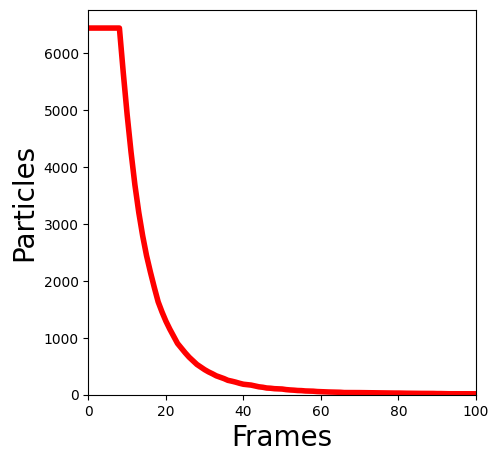

In [63]:
plot_particles_in_frame(p14, 100, None)

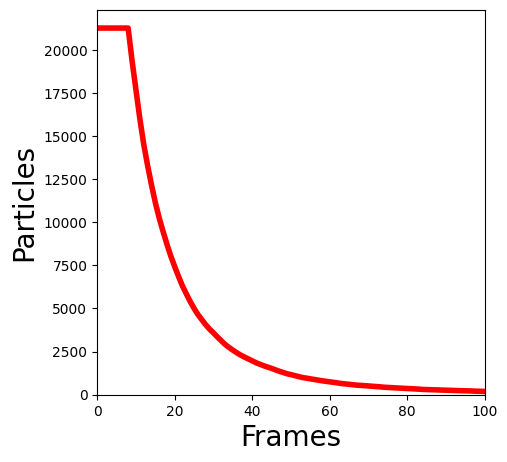

In [64]:
plot_particles_in_frame(p21, 100, None)

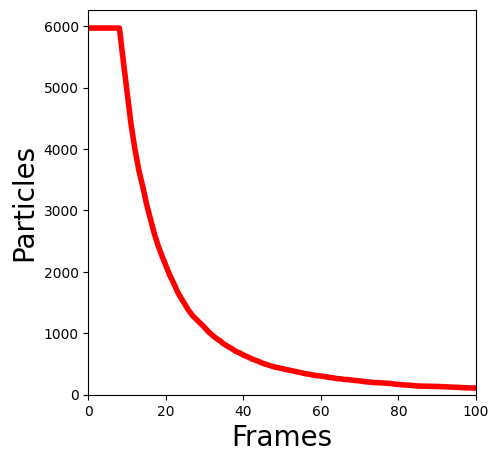

In [67]:
plot_particles_in_frame(p28, 100, None)

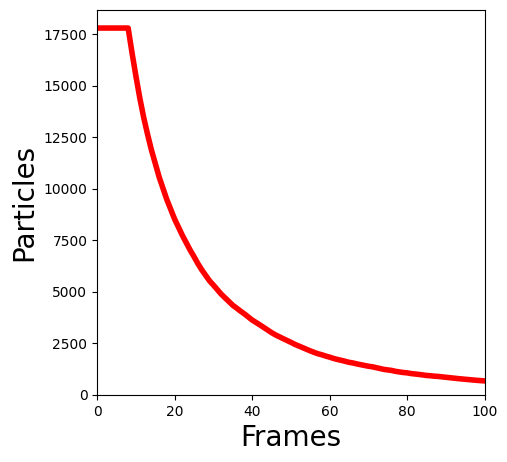

In [65]:
plot_particles_in_frame(p35, 100, None)

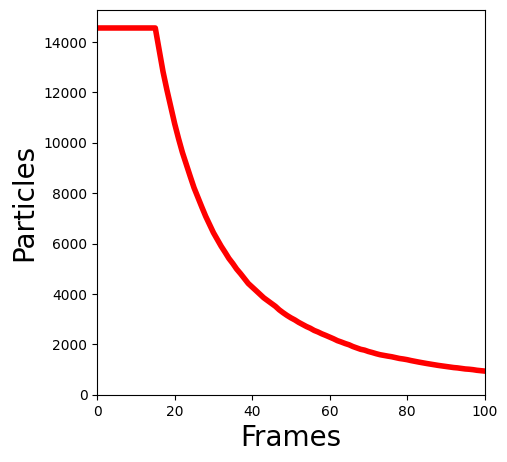

In [66]:
plot_particles_in_frame(p70, 100, None)

In [4]:
def plot_individual_msds(csv, x_range=100, y_range=20, umppx=0.16, fps=100.02, alpha=0.1,
                          figsize=(10, 10), subset=False, size=1000,
                         dpi=300):
    """
    Plot MSDs of trajectories and the geometric average.

    Parameters
    ----------
    prefix: string
        Prefix of file name to be plotted e.g. features_P1.csv prefix is P1.
    x_range: float64 or int
        Desire x range of graph.
    y_range: float64 or int
        Desire y range of graph.
    fps: float64
        Frames per second of video.
    umppx: float64
        Resolution of video in microns per pixel.
    alpha: float64
        Transparency factor.  Between 0 and 1.
    upload: boolean
        True if you want to upload to s3.

    Returns
    -------
    geo_mean: numpy array
        Geometric mean of trajectory MSDs at all time points.
    geo_SEM: numpy array
        Geometric standard errot of trajectory MSDs at all time points.

    """

    merged = csv

    fig = plt.figure(figsize=figsize)
    particles = int(max(merged['Track_ID']))

    if particles < size:
        size = particles - 1
    else:
        pass

    frames = int(max(merged['Frame']))

    y = merged['Y']#.values.reshape((particles+1, frames+1))*umppx*umppx
    x = merged['X']#.values.reshape((particles+1, frames+1))/fps
#     for i in range(0, particles+1):
#         y[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
#         x = merged.loc[merged.Track_ID == i, 'Frame']/fps

    particles = np.linspace(0, particles, particles-1).astype(int)
    if subset:
        particles = np.random.choice(particles, size=size, replace=False)

    y = np.zeros((particles.shape[0], frames+1))
    for idx, val in enumerate(particles):
        y[idx, :] = merged.loc[merged.Track_ID == val, 'MSDs']*umppx*umppx
        x = merged.loc[merged.Track_ID == val, 'Frame']/fps
        plt.plot(x, y[idx, :], 'k', alpha=alpha)

    geo_mean = np.nanmean(ma.log(y), axis=0)
    geo_SEM = stats.sem(ma.log(y), axis=0, nan_policy='omit')
    plt.plot(x, np.exp(geo_mean), 'k', linewidth=4)
    plt.plot(x, np.exp(geo_mean-geo_SEM), 'k--', linewidth=2)
    plt.plot(x, np.exp(geo_mean+geo_SEM), 'k--', linewidth=2)
    plt.xlim(0, x_range)
    plt.ylim(0, y_range)
    plt.xlabel('Tau (s)', fontsize=25)
    plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$)', fontsize=25)


    
    return geo_mean, geo_SEM

In [95]:
p14_msd_file_list[0]

'msd_P14_40nm_s2_v1.csv'

In [96]:
pd.read_csv(age_msd_path+p14_msd_file_list[0])

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity
0,0,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,1,1.0,0.0,NaN,NaN,110.051107,0.956571,NaN,NaN,NaN
2,2,2.0,0.0,NaN,NaN,261.949266,0.696166,NaN,NaN,NaN
3,3,3.0,0.0,NaN,NaN,434.322515,0.800104,NaN,NaN,NaN
4,4,4.0,0.0,NaN,NaN,610.099128,0.705839,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
369763,9109,646.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369764,9110,647.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369765,9111,648.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369766,9112,649.0,567.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(masked_array(data=[--, 0.7189154492128205, 1.4560306683999786,
                    1.8841428440245462, 2.1639624667429453,
                    2.390264972766381, 2.5421169561475336,
                    2.656121988150791, 2.7432987697046785,
                    2.8946764142703088, 2.98541828571988,
                    3.0687777712280733, 3.3021904106992723,
                    3.3376623134850614, 3.4210511824769876,
                    3.475658975787938, 3.4503741251524307,
                    3.8394748436345103, 3.9697562186016073,
                    3.9794985926551205, 4.049169970568924,
                    3.9083866194613126, 3.9292288089324914,
                    3.9977496360058113, 4.149764680181948,
                    3.8452370321449982, 3.9289888041284056,
                    3.897200238672195, 3.9271296488851455,
                    3.940025479468915, 3.8750623041681327,
                    3.844019830970745, 3.8426358884819316,
                    3.4821703807142144, 3.4746

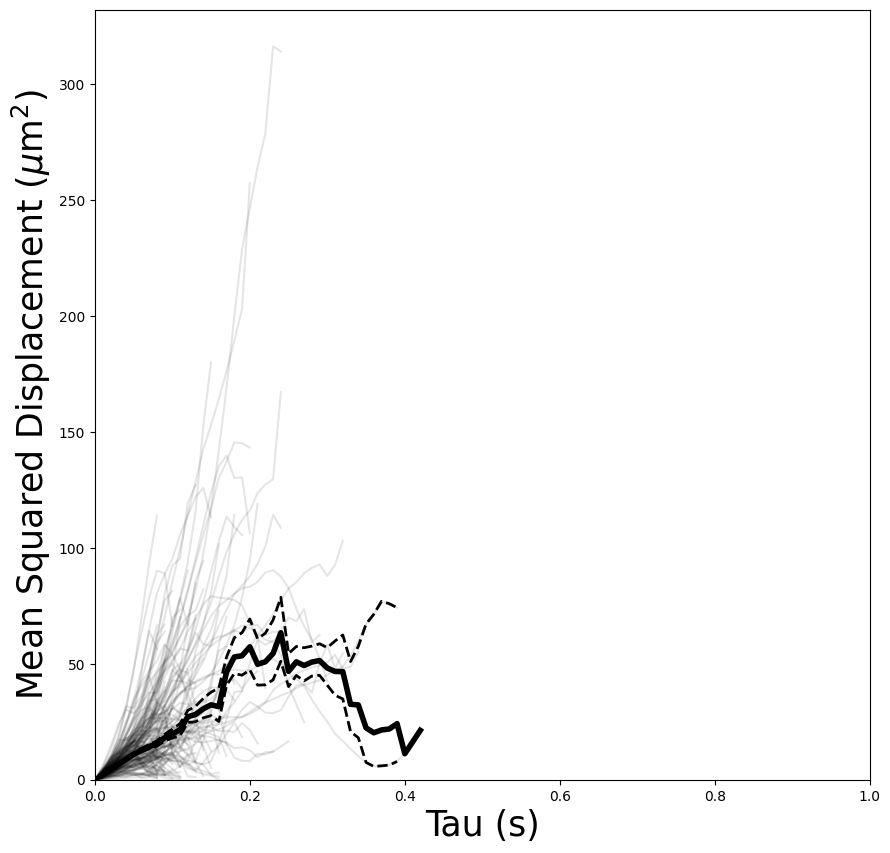

In [30]:
plot_individual_msds(pd.read_csv(age_msd_path+p14_msd_file_list[4]), 1, None)

In [36]:
save_path = age_msd_path+'msd_one_third_sec/'
os.mkdir(save_path)

for file in p14_msd_file_list:
    merged = pd.read_csv(join(age_msd_path, file), encoding='utf-8', index_col='Unnamed: 0')
    plot_individual_msds(merged, x_range=0.35, y_range=250)
    plt.title(file[:-4])
    
    plt.savefig(join(save_path, file[:-4] + '_msd_profile_third_sec_ymax.png'))
    print(f'finished {file[:-4]}')
    plt.close()

finished msd_P14_40nm_s2_v1
finished msd_P14_40nm_s2_v3
finished msd_P14_40nm_s2_v2
finished msd_P14_40nm_s2_v5
finished msd_P14_40nm_s2_v4
finished msd_P14_40nm_s3_v2
finished msd_P14_40nm_s3_v3
finished msd_P14_40nm_s3_v1
finished msd_P14_40nm_s1_v4
finished msd_P14_40nm_s1_v5
finished msd_P14_40nm_s3_v4
finished msd_P14_40nm_s1_v1
finished msd_P14_40nm_s3_v5
finished msd_P14_40nm_s1_v2
finished msd_P14_40nm_s1_v3
